# Sunspot Grouping

In [25]:
from module import getUmbraPenumbra, toSunpyMap

map = toSunpyMap('data/L2/imoa_03933_l2_20240323_13052647_emi1.fts.bz2')

umbra, penumbra = getUmbraPenumbra(map)

Group :

In [26]:
import astropy.units as u
import numpy as np
import cv2 as cv


threshold = 0.05

n_labels, labels, stats, centroids = cv.connectedComponentsWithStats(umbra | penumbra, connectivity=8)

unique_labels = np.arange(1,n_labels)

for label in unique_labels:
    point = map.pixel_to_world(centroids[label][0]*u.pixel, centroids[label][1]*u.pixel)
    
    for other_label in unique_labels:
        if label==other_label:
            continue
        
        other_point = map.pixel_to_world(centroids[other_label][0]*u.pixel, (centroids[other_label][1])*u.pixel)
        
        if point.separation(other_point).value < threshold:
            labels[labels==other_label]=label
            unique_labels = unique_labels[unique_labels!=other_label]


for idx, label in enumerate(np.unique(labels)):
    labels[labels==label]=idx

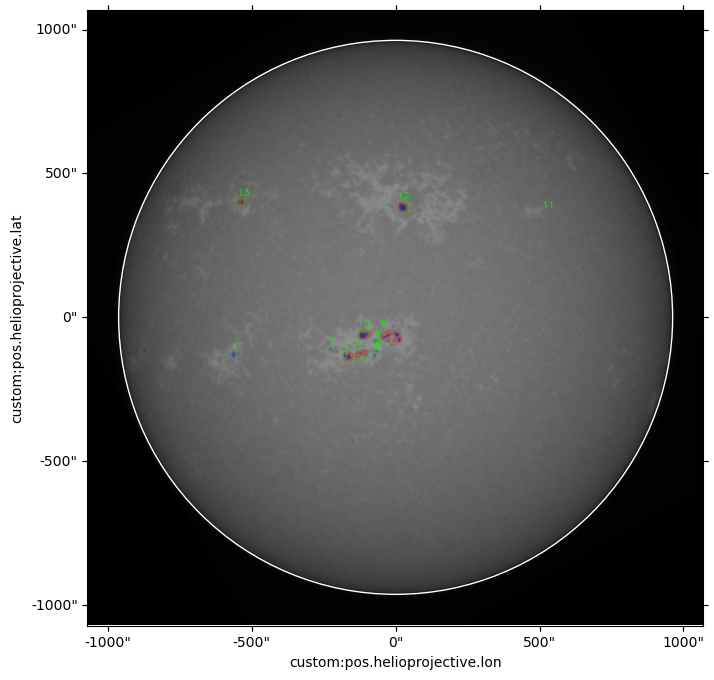

In [43]:
import matplotlib.pyplot as plt
from module import drawSunspots


img = drawSunspots(map)

font = cv.FONT_HERSHEY_DUPLEX

fontScale = 1

color = (0, 255, 0) 

thickness = 1

unique_labels = np.unique(labels)
for label in unique_labels[1:]:
    x,y,w,h = cv.boundingRect((labels==label).astype(np.uint8))
    cv.rectangle(img, (x,y,w,h),(0,255,0),1)
    img = cv.putText(img, f'{label}', (x, y+h+10), font,  
                fontScale, color, thickness, cv.LINE_AA, True)
   
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=map)
plt.imshow(img);
map.draw_limb(axes=ax)

plt.show()

In [28]:
from skimage import measure

regions = measure.regionprops(labels)

group_centroids = np.array([[r.centroid[1], r.centroid[0]] for r in regions]).astype(np.uint16)

# Adding centroid for label 0
group_centroids = np.insert(group_centroids, 0, [1024, 1024], axis=0)

print(group_centroids)

[[1024 1024]
 [ 947  937]
 [ 486  898]
 [1516 1372]
 [1049 1387]
 [ 512 1405]]


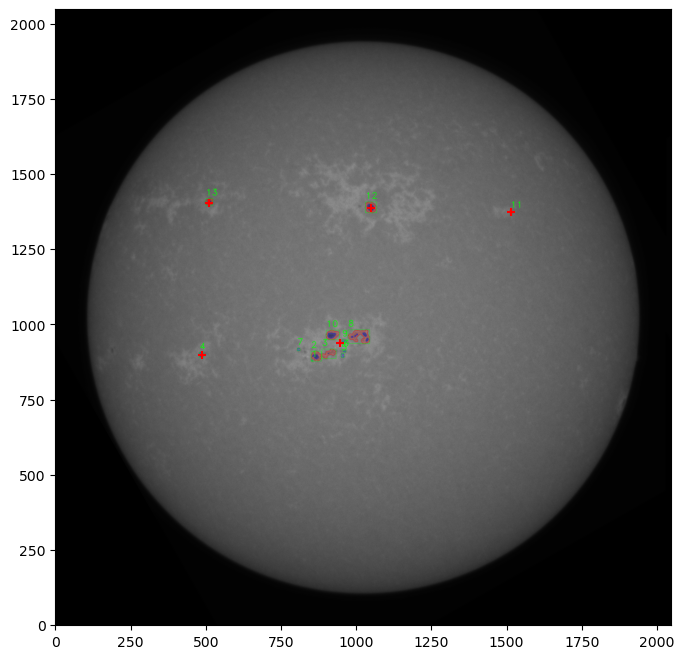

In [44]:
plt.figure(figsize=(8,8))
plt.imshow(img, cmap='gray', origin='lower')

for centroid in group_centroids[1:]:
    plt.scatter(centroid[0], centroid[1], marker='+', color='red')

plt.show()

## Method 2

In [70]:
import astropy.units as u
import numpy as np
import cv2 as cv

import matplotlib.pyplot as plt

In [71]:
from module import getUmbraPenumbra, toSunpyMap

map = toSunpyMap('data/L2/imoa_03933_l2_20240323_13052647_emi1.fts.bz2')

umbra, penumbra = getUmbraPenumbra(map)

n_labels, labels, stats, centroids = cv.connectedComponentsWithStats(umbra | penumbra, connectivity=8)

centroids=centroids[1:]

In [72]:
centroids

array([[ 855.        ,  878.        ],
       [ 868.20174346,  893.25404732],
       [ 911.35302198,  901.95054945],
       [ 486.50289017,  898.03468208],
       [ 955.79130435,  895.49565217],
       [ 962.22222222,  910.77777778],
       [ 809.67123288,  915.2739726 ],
       [1013.71016771,  959.44863732],
       [ 961.60714286,  943.9375    ],
       [ 921.41211519,  964.        ],
       [1516.35135135, 1372.2972973 ],
       [1049.07526882, 1387.96871945],
       [ 512.60556845, 1405.78886311]])

In [73]:
threshold=0.03

groups = []
for i, centroid1 in enumerate(centroids):
    point1 = map.pixel_to_world(centroid1[0]*u.pixel, (centroid1[1])*u.pixel)
    group_found = False
    for group in groups:
        for _, centroid2 in group:
            point2 = map.pixel_to_world(centroid2[0]*u.pixel, (centroid2[1])*u.pixel)
            distance = point1.separation(point2).value 
            if distance < threshold:
                group.append((i+1, centroid1))
                group_found = True
                break
        if group_found:
            break
    if not group_found:
        groups.append([(i+1, centroid1)])

In [74]:
groups

[[(1, array([855., 878.])),
  (2, array([868.20174346, 893.25404732])),
  (3, array([911.35302198, 901.95054945])),
  (5, array([955.79130435, 895.49565217])),
  (6, array([962.22222222, 910.77777778])),
  (7, array([809.67123288, 915.2739726 ])),
  (8, array([1013.71016771,  959.44863732])),
  (9, array([961.60714286, 943.9375    ])),
  (10, array([921.41211519, 964.        ]))],
 [(4, array([486.50289017, 898.03468208]))],
 [(11, array([1516.35135135, 1372.2972973 ]))],
 [(12, array([1049.07526882, 1387.96871945]))],
 [(13, array([ 512.60556845, 1405.78886311]))]]

In [75]:
label_image = np.zeros(labels.shape, dtype=np.uint16)

for idx, group in enumerate(groups):
    for label, centroid in group:
        label_image[labels==label]=idx+1

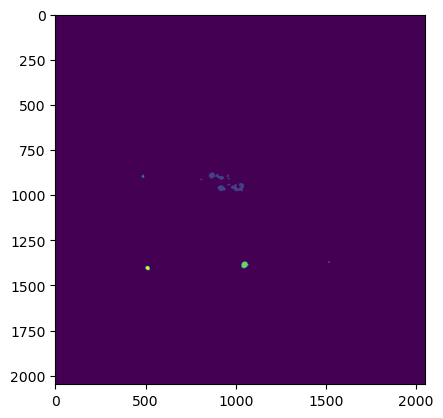

In [76]:
plt.imshow(label_image)

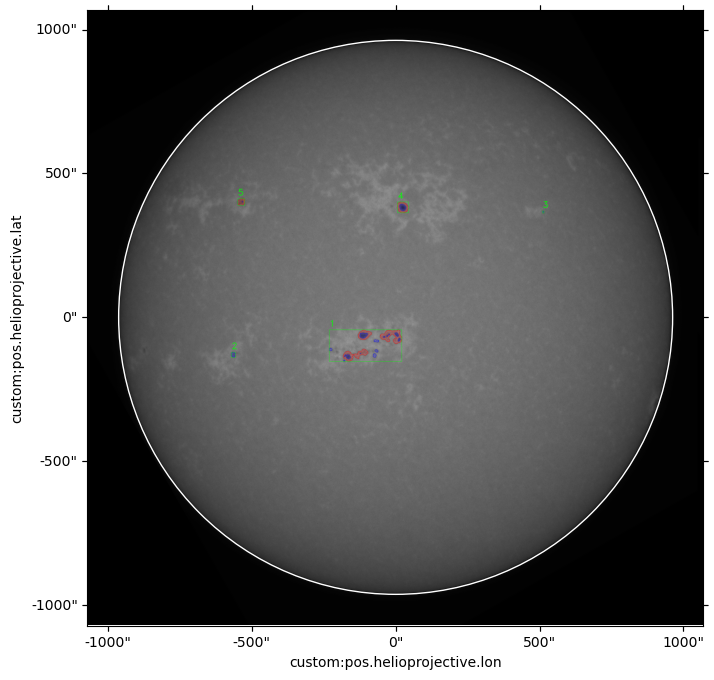

In [77]:
from module import drawSunspots

img = drawSunspots(map)

font = cv.FONT_HERSHEY_DUPLEX

fontScale = 1

color = (0, 255, 0) 

thickness = 1

unique_labels = np.unique(label_image)
for label in unique_labels[1:]:
    x,y,w,h = cv.boundingRect((label_image==label).astype(np.uint8))
    cv.rectangle(img, (x,y,w,h),(0,255,0),1)
    img = cv.putText(img, f'{label}', (x, y+h+10), font,  
                fontScale, color, thickness, cv.LINE_AA, True)
   
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=map)
plt.imshow(img, origin='lower');
map.draw_limb(axes=ax)

plt.show()